In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ppo import PPO
from config_utils import get_config
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
# import gym
# env = gym.make("CartPole-v1")
# env = gym.make("CarRacing-v0")
"""
observation = env.reset()
for _ in range(100):
  env.render()
  action = env.action_space.sample() # your agent here (this takes random actions)
  observation, reward, done, info = env.step(action)

  if done:
        break
    #observation = env.reset()
env.close()
"""

'\nobservation = env.reset()\nfor _ in range(100):\n  env.render()\n  action = env.action_space.sample() # your agent here (this takes random actions)\n  observation, reward, done, info = env.step(action)\n\n  if done:\n        break\n    #observation = env.reset()\nenv.close()\n'

In [4]:
from envs import env_carracing_simple
env = env_carracing_simple.CarRacingSimple()

/Users/jvendrow/opt/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
print(env.action_space)
print(env.action_space.shape)
print(env.observation_space)
print(env.observation_space.shape)
print(type(env.observation_space))

Box(3,)
(3,)
Box(96, 96, 3)
(96, 96, 3)
<class 'gym.spaces.box.Box'>


In [6]:
from actor_critics import ac_utils
print(ac_utils.get_generic_space_size(env.action_space))

3


In [15]:
config = get_config("configs/config-2020_06_02.json")
# config = get_config("configs/config-default_mujoco.json")

config.actor_critic["actor"]["learning_rate"] = 0.5
config.actor_critic["critic"]["learning_rate"] = 0.5
print(config)

# num_epochs = 1200
# num_epochs = 100
num_epochs = 10
minibatch_size = 1

if config.has_training:
    num_epochs = config.training.get("num_epochs", num_epochs)
    minibatch_size = config.training.get("minibatch_size", minibatch_size)

{'ppo_hyperparameters': {'epsilon': 0.2, 'discount_factor': 0.9, 'delta': 0.95, 'actor_critic': {'actor': {'learning_rate': 0.5}, 'critic': {'learning_rate': 0.5, 'alpha': 0.75}}}}


In [16]:
#from actor_critics import carracing_fc_ac
#actor = carracing_fc_ac.Actor(env)
#critic = carracing_fc_ac.Critic(env)

from actor_critics import carracing_cnn_ac
actor = carracing_cnn_ac.Actor(env)
critic = carracing_cnn_ac.Critic(env)

ppo = PPO(
    env,
    config=config,
    actor=actor,
    critic=critic,
    no_cuda=True
)

In [17]:
loss_vals = []
pbar = tqdm(range(num_epochs))
for _ in pbar:
    #for _ in tqdm(range(minibatch_size), desc="minibatch"):
    step_loss_vals = ppo.step()
    loss_vals.append(sum(step_loss_vals) / len(step_loss_vals))
    tqdm.write(str(step_loss_vals))
    pbar.set_description("Loss = {:.6f}".format(loss_vals[-1]))

Track generation: 1222..1540 -> 318-tiles track
[3.4249298572540283, -0.2554165720939636, -0.2554165720939636, -0.2554165720939636, -0.2554165720939636, -0.2554165720939636, -0.2554165720939636, -0.2554165720939636, -0.2554165720939636, -0.2554165720939636]
Track generation: 874..1105 -> 231-tiles track
[3.983642578125, 3.983642578125, 3.983642578125, 3.983642578125, 3.983642578125, 3.983642578125, 3.983642578125, 3.983642578125, 3.983642578125, 3.983642578125]
Track generation: 1062..1339 -> 277-tiles track
[-2.6351819038391113, -2.6351819038391113, -2.6351819038391113, -2.6351819038391113, -2.6351819038391113, -2.6351819038391113, -2.6351819038391113, -2.6351819038391113, -2.6351819038391113, -2.6351819038391113]
Track generation: 1083..1358 -> 275-tiles track
[-2.3475029468536377, -2.3475029468536377, -2.3475029468536377, -2.3475029468536377, -2.3475029468536377, -2.3475029468536377, -2.3475029468536377, -2.3475029468536377, -2.3475029468536377, -2.3475029468536377]
Track generation

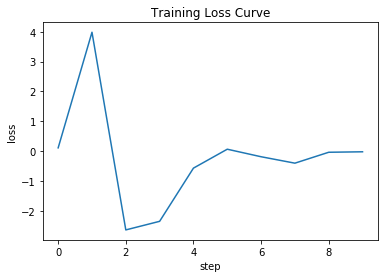

In [18]:
plt.plot(loss_vals)
plt.xlabel("step")
plt.ylabel("loss")
plt.title("Training Loss Curve")
plt.show()

In [19]:
import torch
from torch.autograd import Variable

In [27]:
print(ppo.pi.fc1.weight.grad)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [25]:
#env_new = wrappers.Monitor(env, './video/', force = True)
times = 0
env_new = env
observation = env_new.reset()
# observation = Variable(torch.from_numpy(observation), requires_grad=False).to(ppo.torch_device)
observation = torch.unsqueeze(
    torch.from_numpy(observation.copy()),
    0
).to(ppo.torch_device)
for _ in range(100):
    env_new.render()
    action = torch.argmax(ppo.pi(observation.float())) 
    print("action", action)
    observation, reward, done, info = env_new.step(action.cpu().detach().numpy())
    print(observation.shape)
    # observation = Variable(torch.from_numpy(observation), requires_grad=False).to(ppo.torch_device)
    observation = torch.unsqueeze(
        torch.from_numpy(observation.copy()),
        0
    ).to(ppo.torch_device)
    if not done:
        times += 1
        
print(times)
env_new.close()

Track generation: 1203..1508 -> 305-tiles track
action tensor(6, grad_fn=<NotImplemented>)
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
(96, 96, 3)
action tensor(6, grad_fn=<NotImplemented>)
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
(96, 96, 3)
action tensor(

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
(96, 96, 3)
action tensor(6, grad_fn=<NotImplemented>)
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ..

[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
(96, 96, 3)
action tensor(6, grad_fn=<NotImplemented>)
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ..

action tensor(6, grad_fn=<NotImplemented>)
[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
(96, 96, 3)
action tensor(6, grad_fn=<NotImplemented>)
[[[107 107 107]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 204

action tensor(6, grad_fn=<NotImplemented>)
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
(96, 96, 3)
action tensor(6, grad_fn=<NotImplemented>)
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229

action tensor(6, grad_fn=<NotImplemented>)
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
(96, 96, 3)
action tensor(6, grad_fn=<NotImplemented>)
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
(96, 96, 3)
100


In [ ]:
env.ACTION_MAP